In [162]:
import os
import sys

# Add the src directory to the Python path
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '../src')))

# n_cores = 33
# os.environ["OMP_NUM_THREADS"] = str(n_cores)
# os.environ["MKL_NUM_THREADS"] = str(n_cores)
# os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
# os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

import numpy as np
rnd_gen = np.random.default_rng(2024)
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
from matplotlib_inline.backend_inline import set_matplotlib_formats

# Set the desired output format
set_matplotlib_formats('svg')

from tol_colors import tol_cmap, tol_cset
cmap = tol_cset('bright')
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from online_cp.martingale import PluginMartingale, SimpleJumper
from scipy.optimize import brentq
from tqdm.notebook import tqdm
from online_cp.CPS import RidgePredictionMachine
import pandas as pd

from online_cp.evaluation import Evaluation, CRPS, Err, WinklerScore, Width

from sklearn.datasets import fetch_california_housing

MACHINE_EPSILON = lambda x: np.abs(x) * np.finfo(np.float64).eps

def quantile(p, cdf_func):
# Invert CDF using root-finding (find x such that cdf(x) = p)
    return brentq(lambda x: cdf_func(x) - p, 0, 1)

rnd_gen = np.random.default_rng(2024)

kernel = 'gaussian'
min_sample_size = 3
window_size = None

In [163]:
from online_cp.CPS import ConformalPredictiveDistributionFunction

class protectedRidgeCPD(ConformalPredictiveDistributionFunction):

    def __init__(self, C, B, time_dict=None):
        self.B = B
        self.C = C
        self.L = np.array([self.__call__(y, 0) for y in self.C])
        self.U = np.array([self.__call__(y, 1) for y in self.C])
        self.Y = C
        
        self.time_dict = time_dict

        # What about
        self.y_vals = np.array(sorted([-np.inf, np.inf] + self.C[1: -1].tolist() + (self.C[1: -1] + MACHINE_EPSILON(self.C[1: -1])).tolist() + (self.C[1: -1] - MACHINE_EPSILON(self.C[1: -1])).tolist()))
        self.lowers = np.array([self.__call__(y, 0) for y in self.y_vals])
        self.uppers = np.array([self.__call__(y, 1) for y in self.y_vals])
        # Then the quantile can be computed by
        # self.y_vals[np.where((1 - tau) * self.L + tau * self.U >= p)[0].min()]

    def __call__(self, y, tau=None):
        if y == -np.inf:
            Pi0, Pi1 = 0.0, 0.0
        elif y == np.inf:
            Pi0, Pi1 = 1.0, 1.0
        else:
            C = self.C[:-1]
            idx_eq = np.where(y == C)[0]
            if idx_eq.shape[0] > 0:
                i_prime = idx_eq.min()
                i_bis = idx_eq.max()
                interval = ((i_prime - 1) / C.shape[0], (i_bis + 1) / C.shape[0])
            else:
                i = np.where(C <= y)[0].max()
                interval = (i / C.shape[0], (i + 1) / C.shape[0])

            Pi0 = interval[0]
            Pi1 = interval[1]            

        if tau is None:
            return self.B(Pi0), self.B(Pi1)
        else:
            return self.B((1 - tau) * Pi0 + tau * Pi1)
        
    def quantile(self, p, tau=None):
        def compute_quantile(p, tau):
            # q = np.inf
            # y_vals = np.array(sorted([-np.inf, np.inf] + self.Y[1: -1].tolist() + (self.Y[1: -1] + MACHINE_EPSILON(self.Y[1: -1])).tolist() + (self.Y[1: -1] - MACHINE_EPSILON(self.Y[1: -1])).tolist()))
            # for y in y_vals[::-1]:
            #     if self.__call__(y, tau) >= p:
            #         q = y
            #     else:
            #         return q
            q = self.y_vals[np.where((1 - tau) * self.lowers + tau * self.uppers >= p)[0].min()]
            return q
        if tau is not None:
            q = compute_quantile(p, tau)
            return q
        else:
            q0 = compute_quantile(p, 0)
            q1 = compute_quantile(p, 1)
            return q0, q1
    
        
    def plot(self, tau=None):
        if tau is None:
            fig, ax = plt.subplots()
            ax.step(self.C, self.L, label=r'$\Pi(y, 0)$')
            ax.step(self.C, self.U, label=r'$\Pi(y, 1)$')
            ax.fill_between(self.C, self.L, self.U, step='pre', alpha=0.5, color='green')
            ax.legend()
        else: 
            fig, ax = plt.subplots()
            ax.step(self.C, (1 - tau) * self.L + tau * self.U, label=r'$\Pi(y, \tau)$')
            ax.legend()

        plt.close(fig)  # Prevent implicit display
        return fig

In [164]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
df_red = wine_quality.data.original[wine_quality.data.original.color == 'red'].sample(frac=1, random_state=2025)
df_white = wine_quality.data.original[wine_quality.data.original.color == 'white']

train_size = df_white.shape[0] - df_red.shape[0]
df_train = df_white.sample(train_size, random_state=2025)
# df_train = df_white[:train_size]
df_white_test = df_white.drop(df_train.index)

df_test = pd.concat([df_white_test, df_red])

X_train = df_train.drop(columns=['quality', 'color']).values
X_test = df_test.drop(columns=['quality', 'color']).values
y_train = df_train['quality'].values
y_test = df_test['quality'].values

In [ ]:
epsilon = 0.1

kernel = 'gaussian'
min_sample_size = 100
window_size = None

cps = RidgePredictionMachine(autotune=True)

init_train_size = 20
# Ensure that we can get informative prediction sets from the start
N = 500
X_init_train = X_train#[:N]
y_init_train = y_train#[:N]

X_process = X_test#[:N]
y_process = y_test#[:N]

cps.learn_initial_training_set(X_init_train, y_init_train)

martingale = PluginMartingale(kernel=kernel, warnings=False, window_size=window_size, min_sample_size=min_sample_size)
# martingale = SimpleJumper(warnings=False)

p_values = np.ones_like(y_process)
protected_p_values = np.ones_like(y_process)

protected_p_values = []

base_predictions = {}
protected_predictions = {}

base_efficiency = Evaluation(crps=CRPS)#, err=Err, width=Width, winkler=WinklerScore)
protected_efficiency = Evaluation(crps=CRPS)#, err=Err, width=Width, winkler=WinklerScore)

for i, (obj, lab) in tqdm(enumerate(zip(X_process, y_process)), total=y_process.size):
    tau = rnd_gen.uniform(0, 1)

    # Base prediction
    cpd, precomputed = cps.predict_cpd(obj, return_update=True)

    # Base interval
    # Gamma = cpd.predict_set(tau=tau, epsilon=epsilon, minimise_width=True)
    
    base_predictions[i] = cpd

    # Protected prediction
    protected_cpd = protectedRidgeCPD(C=cpd.C, B=martingale.B_n)
    protected_predictions[i] = protected_cpd

    # Protected interval
    # protected_Gamma = protected_cpd.predict_set(tau=tau, epsilon=epsilon, minimise_width=True)

    p = cpd(lab, tau)
    protected_p = protected_cpd(lab, tau)
    protected_p_values.append(protected_p)

    base_efficiency.update(y=lab, cpd=cpd)#, Gamma=Gamma, epsilon=epsilon)
    protected_efficiency.update(y=lab, cpd=protected_cpd)#, Gamma=protected_Gamma, epsilon=epsilon)

    martingale.update_martingale_value(p)

    # cps.learn_one(obj, lab, precomputed=precomputed)

protected_p_values = np.array(protected_p_values)

  0%|          | 0/500 [00:00<?, ?it/s]

In [166]:
calibration_martingale = PluginMartingale(kernel=kernel, warnings=False, window_size=window_size, min_sample_size=min_sample_size)
# calibration_martingale = SimpleJumper(warnings=False)
for pp in protected_p_values:
    calibration_martingale.update_martingale_value(pp)

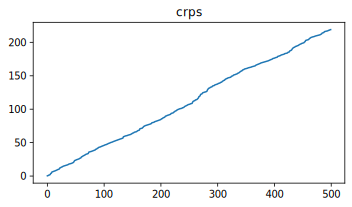

In [167]:
base_efficiency.plot_cumulative_results()

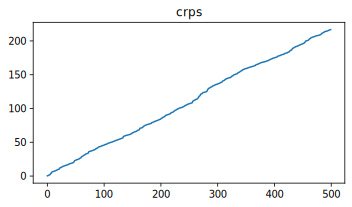

In [168]:
protected_efficiency.plot_cumulative_results()

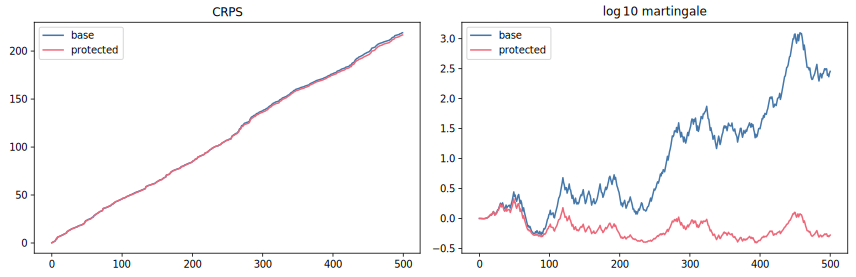

In [169]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

axs[0].plot(np.cumsum(base_efficiency.results['crps']), label='base', color=cmap[0])
axs[0].plot(np.cumsum(protected_efficiency.results['crps']), label='protected', color=cmap[1])
axs[0].legend()
axs[0].set_title('CRPS')

axs[1].plot(martingale.log10_martingale_values, label='base', color=cmap[0])
axs[1].plot(calibration_martingale.log10_martingale_values, label='protected', color=cmap[1])
axs[1].legend()
axs[1].set_title(r'$\log{10}$ martingale')

fig.tight_layout()

Text(0.5, 1.0, 'Overlayed CPD Plots')

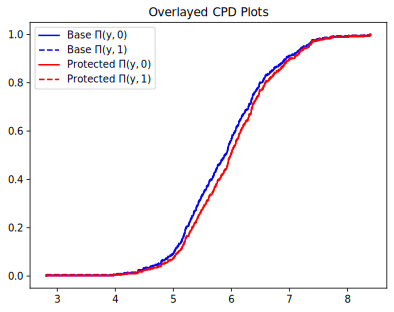

In [170]:
fig, ax = plt.subplots()

# Plot the base CPD
ax.step(cpd.C, cpd.L, label=r'Base $\Pi(y, 0)$', color='blue')
ax.step(cpd.C, cpd.U, label=r'Base $\Pi(y, 1)$', color='blue', linestyle='--')

# Plot the protected CPD
ax.step(protected_cpd.C, protected_cpd.L, label=r'Protected $\Pi(y, 0)$', color='red')
ax.step(protected_cpd.C, protected_cpd.U, label=r'Protected $\Pi(y, 1)$', color='red', linestyle='--')

# Add a shaded region for the protected CPD
ax.fill_between(protected_cpd.C, protected_cpd.L, protected_cpd.U, step='pre', alpha=0.3, color='red')

# Add a shaded region for the base CPD
ax.fill_between(cpd.C, cpd.L, cpd.U, step='pre', alpha=0.3, color='blue')

ax.legend()
ax.set_title('Overlayed CPD Plots')
# plt.close(fig)  # Prevent implicit display

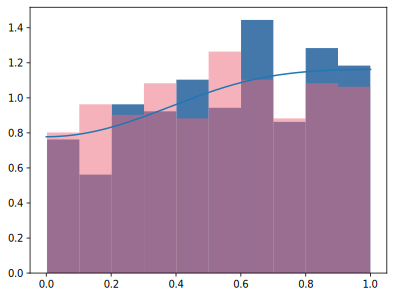

In [171]:
yrange = np.linspace(0, 1, num=1000, endpoint=True)
plt.hist(martingale.p_values, density=True, color=cmap[0])
plt.hist(protected_p_values, density=True, alpha=0.5, color=cmap[1])
plt.plot(
    yrange,
    martingale.b_n(yrange)
)

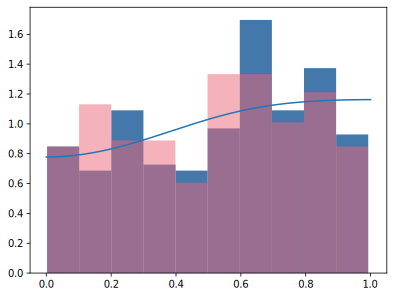

In [172]:
yrange = np.linspace(0, 1, num=1000, endpoint=True)
plt.hist(martingale.p_values[:int(N//2)], density=True, color=cmap[0])
plt.hist(protected_p_values[:int(N//2)], density=True, alpha=0.5, color=cmap[1])
plt.plot(
    yrange,
    martingale.b_n(yrange)
)

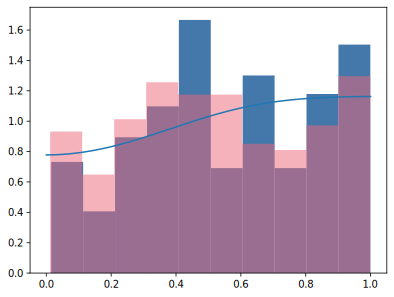

In [173]:
yrange = np.linspace(0, 1, num=1000, endpoint=True)
plt.hist(martingale.p_values[int(N//2):], density=True, color=cmap[0])
plt.hist(protected_p_values[int(N//2):], density=True, alpha=0.5, color=cmap[1])
plt.plot(
    yrange,
    martingale.b_n(yrange)
)